# ORF recognition by CNN

Like 118 but use more layers of CNN.

In [41]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-11 20:20:39 UTC'

In [42]:
PC_SEQUENCES=4000   # how many protein-coding sequences
NC_SEQUENCES=4000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=36            # how long is each sequence
CDS_LEN=18            # min CDS len to be coding
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 16   # how many different patterns the model looks for
NEURONS = 16
DROP_RATE = 0.4
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=25  # how many times to train on all the data
SPLITS=5  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=5  # train the model this many times (range 1 to SPLITS)

In [43]:
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_gen import *
    from SimTools.RNA_describe import ORF_counter
    from SimTools.RNA_prep import *

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_gen():
    print("ERROR: Cannot use RNA_gen.")
if not assert_imported_RNA_prep():
    print("ERROR: Cannot use RNA_prep.")

On Google CoLab, mount cloud-local file, get our code from GitHub.


In [44]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import Flatten,MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [45]:
import random
def partition_random_sequences(goal_per_class):
    pc_seqs=[]
    nc_seqs=[]
    oc = ORF_counter()
    trials = 0
    pc_cnt = 0
    nc_cnt = 0
    bases=['A','C','G','T']
    while pc_cnt<goal_per_class or nc_cnt<goal_per_class:
        trials += 1        
        between_bases = random.randint(0,RNA_LEN-6) 
        utr5_bases = (RNA_LEN - (between_bases + 6)) // 2
        utr3_bases = RNA_LEN - (utr5_bases + (between_bases+6))
        one_seq  = "".join(random.choices(bases,k=utr5_bases)) 
        one_seq += 'ATG'    
        one_seq += "".join(random.choices(bases,k=between_bases)) 
        random_stop = random.choice(['TAA','TAG','TGA']) # random frame
        one_seq += random_stop
        one_seq += "".join(random.choices(bases,k=utr3_bases))  
        if len(one_seq) != RNA_LEN:
            print("WRONG LENGTH:",len(one_seq),utr5_bases,between_bases,utr3_bases)
        oc.set_sequence(one_seq)
        cds_len = oc.get_max_cds_len() + 3
        if cds_len >= CDS_LEN and pc_cnt<goal_per_class:
            pc_cnt += 1
            pc_seqs.append(one_seq)
        elif cds_len < CDS_LEN and nc_cnt<goal_per_class:
            nc_cnt += 1
            nc_seqs.append(one_seq)
    print ("It took %d trials to reach %d per class."%(trials,goal_per_class))
    return pc_seqs,nc_seqs
pc_all,nc_all=partition_random_sequences(10)  # just testing
pc_all,nc_all=partition_random_sequences(PC_SEQUENCES+PC_TESTS)
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

It took 22 trials to reach 10 per class.
It took 14023 trials to reach 5000 per class.
Use 5000 PC seqs
Use 5000 NC seqs


In [46]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 36.0
Average ORF length: 19.8462
NC seqs
Average RNA length: 36.0
Average ORF length: 2.022


In [47]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [48]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [49]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    dnn.add(Flatten())
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (36, 4)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 36, 16)            208       
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 36, 16)            784       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 18, 16)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 18, 16)            784       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 18, 16)            784       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 9, 16)             0         
_________________________________________________________________
flatten_8 (Flatten)     

In [50]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (36, 4)
FIT
Epoch 1/25
200/200 [==============================] - 2s 5ms/step - loss: 0.7203 - accuracy: 0.5034 - val_loss: 0.6821 - val_accuracy: 0.5713
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 2/25
200/200 [==============================] - 1s 4ms/step - loss: 0.6771 - accuracy: 0.5709 - val_loss: 0.6605 - val_accuracy: 0.6081
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 3/25
200/200 [==============================] - 1s 3ms/step - loss: 0.6559 - accuracy: 0.6007 - val_loss: 0.6366 - val_accuracy: 0.6381
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 4/25
200/200 [==============================] - 1s 3ms/step - loss: 0.6102 - accuracy: 0.6630 - val_loss: 0.6134 - val_accuracy: 0.6656
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 5/25
200/200 [==============================] - 1s 3ms/step - loss: 0.5803 - accuracy: 0.6946 - val_loss: 0.5938 - val_accuracy: 0.6888
INFO:tensorflow:Assets written to: BestMod

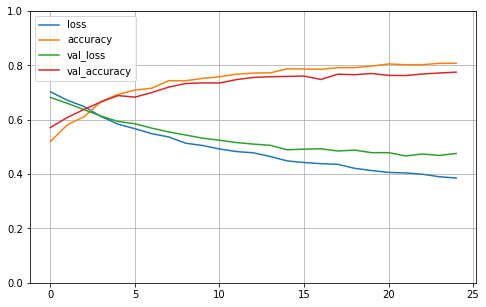

MODEL
make_DNN
input shape: (36, 4)
FIT
Epoch 1/25
200/200 [==============================] - 2s 5ms/step - loss: 0.7218 - accuracy: 0.4942 - val_loss: 0.6890 - val_accuracy: 0.5163
Epoch 2/25
200/200 [==============================] - 1s 3ms/step - loss: 0.6886 - accuracy: 0.5273 - val_loss: 0.6729 - val_accuracy: 0.5856
Epoch 3/25
200/200 [==============================] - 1s 4ms/step - loss: 0.6696 - accuracy: 0.5906 - val_loss: 0.6388 - val_accuracy: 0.6381
Epoch 4/25
200/200 [==============================] - 1s 3ms/step - loss: 0.6265 - accuracy: 0.6538 - val_loss: 0.6046 - val_accuracy: 0.6781
Epoch 5/25
200/200 [==============================] - 1s 3ms/step - loss: 0.6033 - accuracy: 0.6776 - val_loss: 0.5852 - val_accuracy: 0.7013
Epoch 6/25
200/200 [==============================] - 1s 4ms/step - loss: 0.5711 - accuracy: 0.7098 - val_loss: 0.5684 - val_accuracy: 0.7125
Epoch 7/25
200/200 [==============================] - 1s 3ms/step - loss: 0.5432 - accuracy: 0.7255 - val_lo

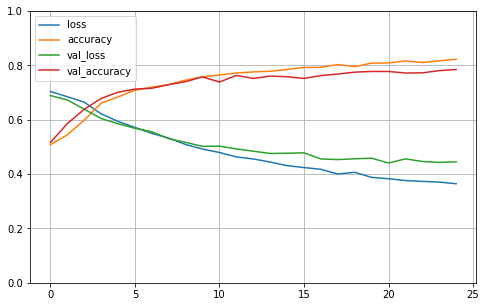

MODEL
make_DNN
input shape: (36, 4)
FIT
Epoch 1/25
200/200 [==============================] - 2s 5ms/step - loss: 0.7275 - accuracy: 0.5148 - val_loss: 0.6809 - val_accuracy: 0.5831
Epoch 2/25
200/200 [==============================] - 1s 3ms/step - loss: 0.6780 - accuracy: 0.5679 - val_loss: 0.6577 - val_accuracy: 0.6187
Epoch 3/25
200/200 [==============================] - 1s 3ms/step - loss: 0.6535 - accuracy: 0.6111 - val_loss: 0.6268 - val_accuracy: 0.6606
Epoch 4/25
200/200 [==============================] - 1s 3ms/step - loss: 0.6215 - accuracy: 0.6580 - val_loss: 0.5994 - val_accuracy: 0.6831
Epoch 5/25
200/200 [==============================] - 1s 4ms/step - loss: 0.5909 - accuracy: 0.6861 - val_loss: 0.5829 - val_accuracy: 0.6988
Epoch 6/25
200/200 [==============================] - 1s 3ms/step - loss: 0.5668 - accuracy: 0.7095 - val_loss: 0.5662 - val_accuracy: 0.7106
Epoch 7/25
200/200 [==============================] - 1s 4ms/step - loss: 0.5591 - accuracy: 0.7074 - val_lo

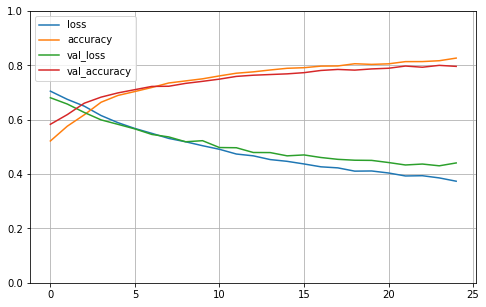

MODEL
make_DNN
input shape: (36, 4)
FIT
Epoch 1/25
200/200 [==============================] - 2s 5ms/step - loss: 0.7246 - accuracy: 0.5071 - val_loss: 0.6839 - val_accuracy: 0.5863
Epoch 2/25
200/200 [==============================] - 1s 3ms/step - loss: 0.6811 - accuracy: 0.5503 - val_loss: 0.6593 - val_accuracy: 0.5950
Epoch 3/25
200/200 [==============================] - 1s 4ms/step - loss: 0.6530 - accuracy: 0.6256 - val_loss: 0.6280 - val_accuracy: 0.6444
Epoch 4/25
200/200 [==============================] - 1s 4ms/step - loss: 0.6243 - accuracy: 0.6507 - val_loss: 0.5848 - val_accuracy: 0.6950
Epoch 5/25
200/200 [==============================] - 1s 3ms/step - loss: 0.5879 - accuracy: 0.6924 - val_loss: 0.5715 - val_accuracy: 0.6969
Epoch 6/25
200/200 [==============================] - 1s 4ms/step - loss: 0.5637 - accuracy: 0.7133 - val_loss: 0.5561 - val_accuracy: 0.7088
Epoch 7/25
200/200 [==============================] - 1s 3ms/step - loss: 0.5502 - accuracy: 0.7276 - val_lo

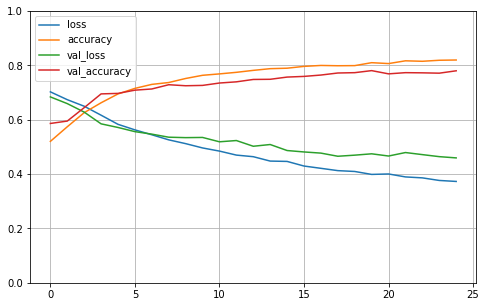

MODEL
make_DNN
input shape: (36, 4)
FIT
Epoch 1/25
200/200 [==============================] - 2s 5ms/step - loss: 0.7066 - accuracy: 0.5119 - val_loss: 0.6857 - val_accuracy: 0.5481
Epoch 2/25
200/200 [==============================] - 1s 4ms/step - loss: 0.6840 - accuracy: 0.5490 - val_loss: 0.6755 - val_accuracy: 0.5594
Epoch 3/25
200/200 [==============================] - 1s 3ms/step - loss: 0.6676 - accuracy: 0.6039 - val_loss: 0.6510 - val_accuracy: 0.6100
Epoch 4/25
200/200 [==============================] - 1s 4ms/step - loss: 0.6404 - accuracy: 0.6309 - val_loss: 0.6105 - val_accuracy: 0.6762
Epoch 5/25
200/200 [==============================] - 1s 3ms/step - loss: 0.6026 - accuracy: 0.6774 - val_loss: 0.5853 - val_accuracy: 0.6844
Epoch 6/25
200/200 [==============================] - 1s 4ms/step - loss: 0.5710 - accuracy: 0.7132 - val_loss: 0.5638 - val_accuracy: 0.7006
Epoch 7/25
200/200 [==============================] - 1s 3ms/step - loss: 0.5353 - accuracy: 0.7332 - val_lo

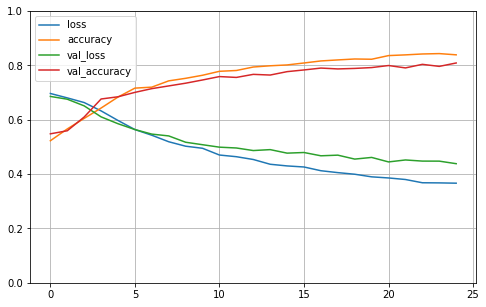

In [51]:
do_cross_validation(X,y)

In [52]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 81.00%


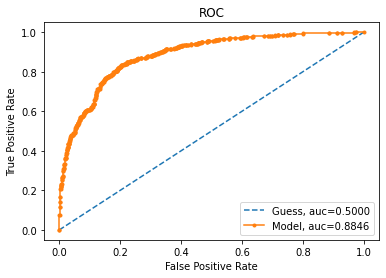

AUC: 88.46%


In [53]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [54]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-11 20:23:34 UTC'